<a href="https://colab.research.google.com/github/bhavya5678369/Power-Market-Trading-Model-with-ARIMA-/blob/main/Power_Algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0571
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0033
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0023
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0024
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0021
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0020
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0021
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0019
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0019
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0020
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0014
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0015
Epoch 13/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0014
Epoch 14/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0013
Epoch 15/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step 

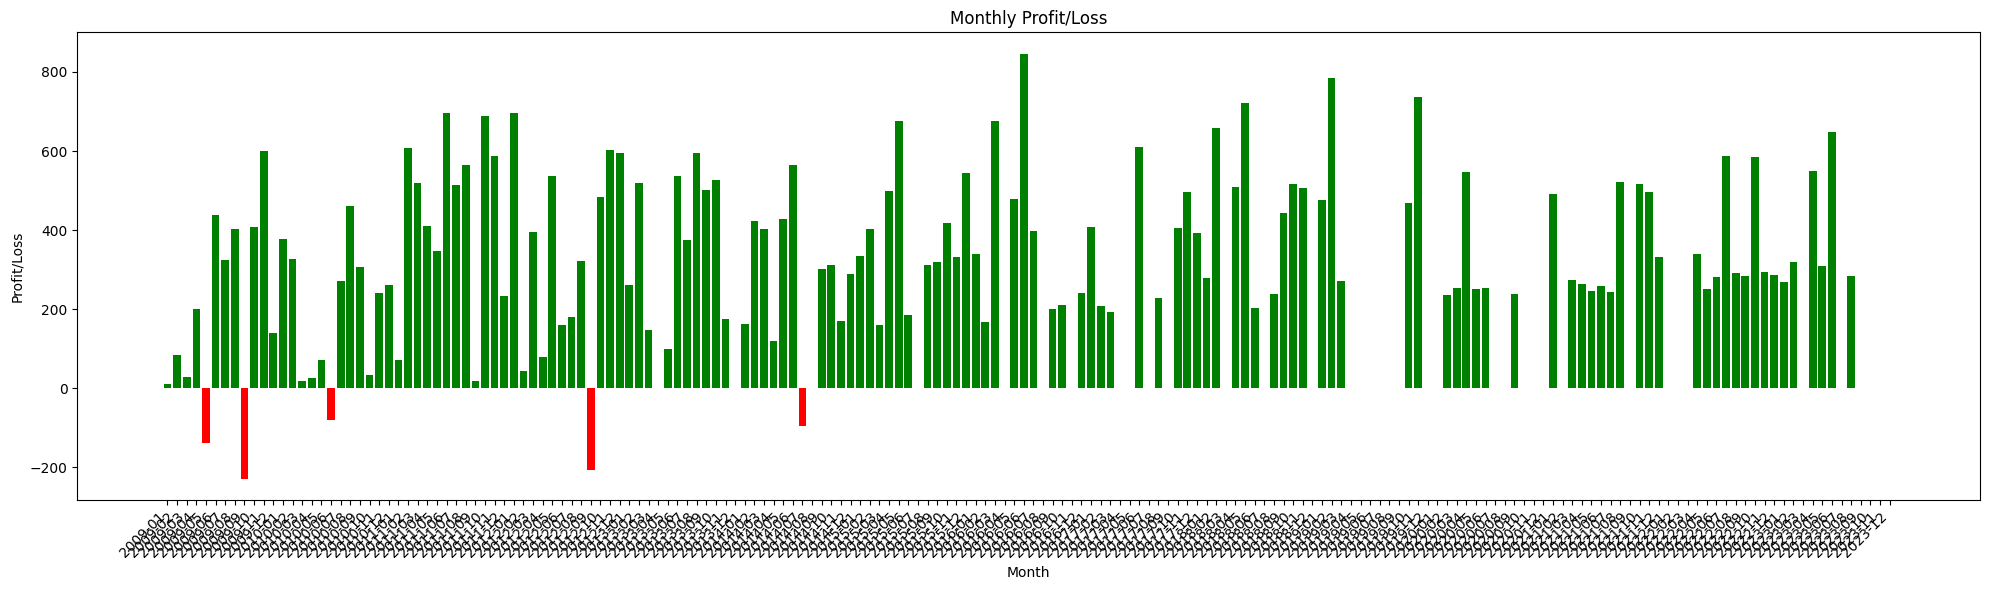

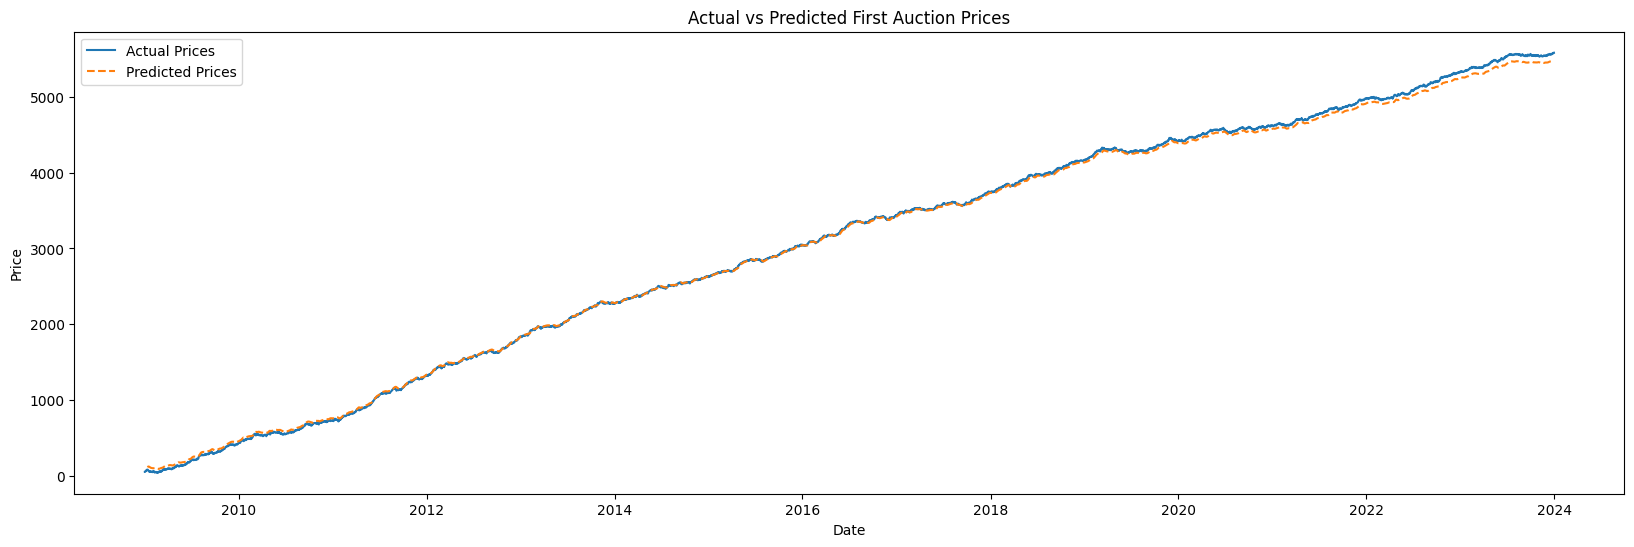

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Fetch historical power market data (placeholder)
def get_historical_power_data(start_date, end_date):
    num_days = pd.date_range(start_date, end_date).shape[0]
    np.random.seed(42)
    prices = np.cumsum(np.random.randn(num_days) * 5 + 1) + 50
    second_prices = prices + np.random.normal(0, 10, num_days)

    data = pd.DataFrame(
        {
            "FirstAuctionPrice": prices,
            "SecondAuctionPrice": second_prices,
        },
        index=pd.date_range(start_date, end_date, freq="D"),
    )

    return data

# Get historical power market data
prices = get_historical_power_data("2009-01-01", "2023-12-31")

# Preprocessing for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices["FirstAuctionPrice"].values.reshape(-1, 1))

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare data for LSTM
time_step = 10
X, Y = create_dataset(scaled_prices, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, Y, epochs=50, batch_size=32, verbose=1)

# Making predictions
train_predict = model.predict(X)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)

# Add predictions to the original prices DataFrame for plotting
prices['Predicted'] = np.nan
prices.iloc[time_step:len(train_predict) + time_step, 2] = train_predict.flatten()

# Enhanced Trading Logic
def trading_strategy(current_price, portfolio):
    quantity = 10
    pnl = 0

    # Buy condition: if we have no holdings, buy
    if portfolio["holdings"] == 0:
        portfolio["buy_price"] = current_price
        portfolio["holdings"] += quantity
        return 0  # No PnL yet since it's a buy

    # Sell condition: if the price increases by more than 0.5%
    elif current_price > portfolio["buy_price"] * 1.005:  # 0.5% take profit
        pnl = (current_price - portfolio["buy_price"]) * portfolio["holdings"]
        portfolio["buy_price"] = None
        portfolio["holdings"] = 0
        return pnl

    # Adjust sell condition: if the price decreases by more than 1.5%
    elif current_price < portfolio["buy_price"] * 0.985:  # 1.5% stop-loss
        pnl = (current_price - portfolio["buy_price"]) * portfolio["holdings"]
        portfolio["buy_price"] = None
        portfolio["holdings"] = 0
        return pnl

    # Re-entry condition: If the price drops by 1% from the last buy price and we currently have no holdings
    elif portfolio["holdings"] == 0 and current_price < portfolio["buy_price"] * 0.99:
        portfolio["buy_price"] = current_price
        portfolio["holdings"] += quantity
        return 0  # No PnL since it's a buy

    # If no trading action, return zero PnL
    return 0

# Backtesting Loop
portfolio = {"holdings": 0, "buy_price": None}
monthly_profits = {}
total_pnl = 0

for date, row in prices.iterrows():
    current_price = row["FirstAuctionPrice"]
    daily_profit = trading_strategy(current_price, portfolio)

    month = date.strftime("%Y-%m")
    monthly_profits.setdefault(month, 0)
    monthly_profits[month] += daily_profit

    total_pnl += daily_profit

# Store monthly profits in a DataFrame
monthly_profits_data = []
for month, profit in monthly_profits.items():
    monthly_profits_data.append({"Month": month, "Profit/Loss": profit})

# Create a pandas DataFrame from the profit data
profit_table = pd.DataFrame(monthly_profits_data)

# Display the profit table
print(profit_table)
print(f"\nTotal PnL over the period: {total_pnl}")

# Visualization of Monthly Profit/Loss
plt.figure(figsize=(20, 6))
plt.bar(profit_table['Month'], profit_table['Profit/Loss'], color=['green' if p > 0 else 'red' for p in profit_table['Profit/Loss']])
plt.title('Monthly Profit/Loss')
plt.xlabel('Month')
plt.ylabel('Profit/Loss')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization of Actual vs Predicted Prices
plt.figure(figsize=(20, 6))
plt.plot(prices.index, prices['FirstAuctionPrice'], label='Actual Prices')
plt.plot(prices.index, prices['Predicted'], label='Predicted Prices', linestyle='--')
plt.title('Actual vs Predicted First Auction Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
